*Highly Recommend opening this notebook on Google Colab. A number of Text cells will not show up on GitHub.*

⚠️ <a href="https://colab.research.google.com/github/AlaFalaki/workshop-materials/blob/main/2021-practical-deep-learning/03-Vision_Part1.ipynb"> Click Here To Open in Google Colab </a> ⚠️

# Practical Deep Learning Workshop (Part 3)

# Vision

* Start with looking at a [Demo](https://colab.research.google.com/github/AlaFalaki/workshop-materials/blob/main/2021-practical-deep-learning/05-Vision_Demo.ipynb)
* See an example of loading a dataset,
* Training the Model
* And, Interpret its Output


# Install FastAI2

> Run the cell below to install FastAI2. <br /><br />
> ⚠️ Make sure to restart the current runtime after the installation for changes to affect. Select 'Runtime' From the top menu and click on 'Restart Runtime'.

In [1]:
!pip install -Uq fastai

     |████████████████████████████████| 188 kB 8.5 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 


In [2]:
from fastai.vision.all import *

# Download the Data

> We are using a dataset called Flowers [1], which consists of images of flowers and their labels (102 different categories).

In [3]:
path = untar_data( URLs.FLOWERS, dest="./" )
path

Path('oxford-102-flowers')

## Preprocess the Data

> Load the dataset using the Pandas DataFrame and look inside.

In [4]:
train_df = pd.read_csv(path/'train.txt', sep=' ', header=None, names=['link', 'label'])
test_df  = pd.read_csv(path/'test.txt' , sep=' ', header=None, names=['link', 'label'])
valid_df = pd.read_csv(path/'valid.txt', sep=' ', header=None, names=['link', 'label'])

In [5]:
train_df.head()

,link,label
0,jpg/image_03860.jpg,16
1,jpg/image_06092.jpg,13
2,jpg/image_02400.jpg,42
3,jpg/image_02852.jpg,55
4,jpg/image_07710.jpg,96


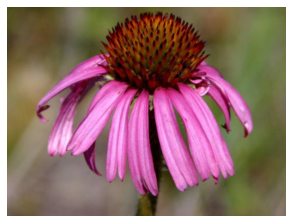

In [6]:
img = PILImage.create(path/train_df.iloc[0]['link'])
img.show()

> We can have access to all images and their labels from the created dataframes. Unfortunately, the dataset does not have human-readable labels. So, we need to download the labels from elsewhere. <br /> <br />
The labels come in a text file where each line contains one label. We can load a text file line-by-line with the following code:

In [7]:
!wget https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt

--2021-07-23 01:34:37--  https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘Oxford-102_Flower_dataset_labels.txt’

Oxford-102_Flower_d 100%[===================>]   1.57K  --.-KB/s    in 0s      

2021-07-23 01:34:37 (33.4 MB/s) - ‘Oxford-102_Flower_dataset_labels.txt’ saved [1608/1608]



In [8]:
class_labels = open('Oxford-102_Flower_dataset_labels.txt', 'r')
classes = class_labels.readlines()

label_names = []
for item in classes:
  label_names.append(item[2:-2])

In [9]:
label_names[:5]

['pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold']

> Now, we can convert the label ids to human-readable labels so that FastAI takes care of encoding them to have one unified representation. It can convert them back to Ids on training time and back to strings to show the predicted labels.

In [10]:
train_df['label'] = train_df['label'].apply(lambda x: label_names[x])
test_df ['label'] = test_df ['label'].apply(lambda x: label_names[x])
valid_df['label'] = valid_df['label'].apply(lambda x: label_names[x])

In [11]:
train_df.head()

,link,label
0,jpg/image_03860.jpg,purple coneflower
1,jpg/image_06092.jpg,spear thistle
2,jpg/image_02400.jpg,sword lily
3,jpg/image_02852.jpg,bishop of llandaff
4,jpg/image_07710.jpg,mallow


In [12]:
print( "Train set: {} / Validation set: {} / Test set: {} ".format(len(train_df), len(valid_df), len(test_df)) )

Train set: 1020 / Validation set: 1020 / Test set: 6149 


> Because there is a huge imbalance in the number of samples on different sets. We can shuffle the data our own way.<br /><br />
⚠️ If you prepare a model for a competition or a study, you can not shuffle the data on your own. You need to follow specific guidelines.

In [13]:
train_df = pd.concat([train_df, test_df], axis=0)
test_df  = valid_df.copy()

In [14]:
print( "Train set: {} / Test set: {} ".format(len(train_df), len(test_df)) )

Train set: 7169 / Test set: 1020 


> New Train set = Train set + Test set <br />
New Test set = Validation set <br /><br />
I did not make a separate validation set because FastAI can also take care of that for us.<br />
Let's load the data using the Dataloader.

In [15]:
img.shape

(500, 667)

# Make the Dataloader

## Using ImageDataLoaders

> Like what we saw for the NLP, FastAi provides an *ImageDataLoaders* class that can read the data from either dataframes and directories. But are these dataloaders flexible enough? What if you want to load data for a task like text translation?

In [17]:
dls = ImageDataLoaders.from_df(train_df, path="oxford-102-flowers", item_tfms=Resize(500),
                               batch_tfms=aug_transforms(size=250))

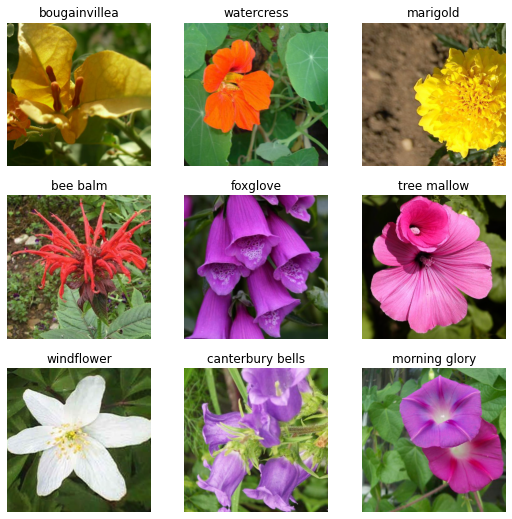

In [18]:
dls.show_batch()

> ⚠️ **item_tfms vs. batch_tfms:**<br /><br />
The difference between these two is that the first one does the processing while making the Dataloader. And the second one does its augmentation during training while the data is on GPU and using the GPU. So, it will be much faster.

## Using DataBlock API (More flexible)

> You can load any kind of data for any kind of problem using the DataBloack API. You just need to specify the blocks in order and set functions for loading them. You can select blocks for a wide range of applications.<br /><br />
*ImageBlock, MaskBlock (Segmentation), PointBlock, BBoxBlock, BBoxLblBlock (Bounding Box), TextBlock (NLP), CategoryBlock (Classification), MultiCategoryBlock (Multi-Class Classification), ...*<br /><br />
These blocks can be found on the documentation with examples of their usage.

In [19]:
def get_x(x): return path/x['link']
def get_y(x): return x['label']

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(seed=42),
                   get_x=get_x,
                   get_y=get_y, 
                   item_tfms = Resize(500),
                   batch_tfms=aug_transforms(size=250)) 

In [20]:
dls = dblock.dataloaders( train_df )

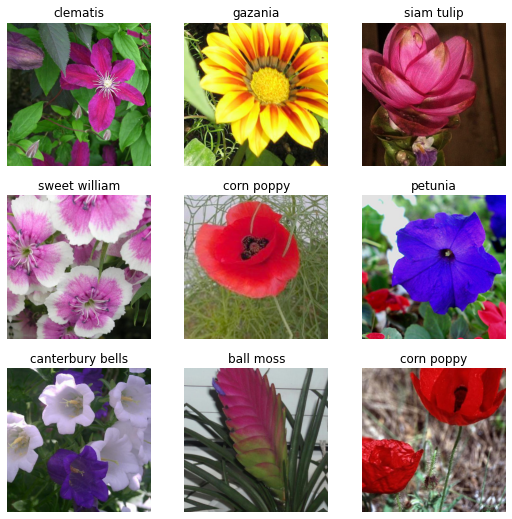

In [21]:
dls.show_batch()

# Make the Learner

> FastAI uses several pre-trained models directly from the PyTorch vision library (torchvision). For example, we used pre-trained ResNet [2] here with 34 layers. There are other deeper options like resnet50, resnet101, resnet152,... Or even other models like AlexNet and VGG (find more in documentation).<br /><br />
The **fine_tune()** function will (same as NLP) freeze the whole model except the classification head and train it for *freeze_epochs* number of times. (Here we set it to 2) Then, unfreeze the entire model and train it for *epochs* times with half the learning rate. (set to 10)

In [23]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [22]:
learn.fine_tune(10, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,time
0,4.164664,1.583763,0.618981,00:57
1,1.541623,0.399419,0.900209,00:57


epoch,train_loss,valid_loss,accuracy,time
0,0.478643,0.221982,0.944871,01:00
1,0.301587,0.151659,0.959525,01:00
2,0.214698,0.168074,0.951849,01:00
3,0.127928,0.116282,0.969295,01:01
4,0.086407,0.092248,0.973482,01:00
5,0.057875,0.093933,0.972784,01:00
6,0.034554,0.068831,0.981158,01:00
7,0.023437,0.058161,0.982554,01:00
8,0.016238,0.052720,0.986043,01:02
9,0.012558,0.054230,0.985345,01:01


# Analyze the Model Performance

> Let's see the loss value changes during training. It seems that we can get away with training for at least 2 more epochs based on the speed that loss value is decreasing.<br /><br />
If you see a large increase in validation loss, but the training loss is still decreasing, it means your model is overfitting. Try a smaller model, more data, more dropout, ...

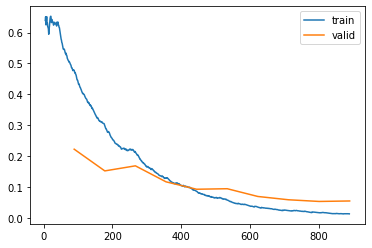

In [23]:
learn.recorder.plot_loss()

> Add the test set to the Dataloader so we can evaluate our model on it. By calling the validate() function. Its first output is the loss value on the test set, and the second one is the accuracy.

In [24]:
tst_dl = dls.test_dl(test_df, with_labels=True)

In [25]:
len(test_df)

1020

In [26]:
learn.validate(dl=tst_dl)

(#2) [0.09117527306079865,0.9764705896377563]

> Lets see how confuse our model is...

In [27]:
interp = ClassificationInterpretation.from_learner(learn, dl=tst_dl)

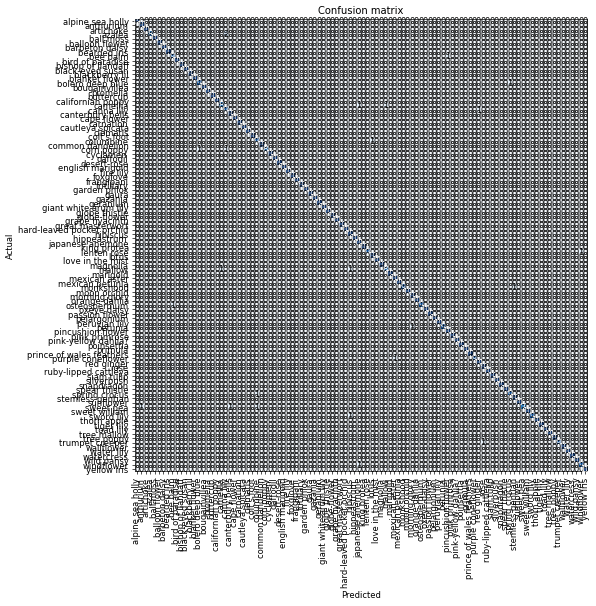

In [29]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

> See a larger interp result. [Here](https://raw.githubusercontent.com/AlaFalaki/workshop-materials/main/2021-practical-deep-learning/materials/interp-res.png) 

In [30]:
interp.most_confused(min_val=2)

[('azalea', 'canna lily', 2)]

> The above function will print out the labels where the model has the most trouble predicting at least *min_val* number of times. For example, 2 cases in the results that the model predicted an *azalea* as *canna lily*. **If you encounter something like this, you can either add more data of a specific label to the model or try adjusting hyperparameters like the number of epochs and learning rate. Maybe even using augmentation to make the images black and white.**

> We can also plot the cases that model was most confused about.

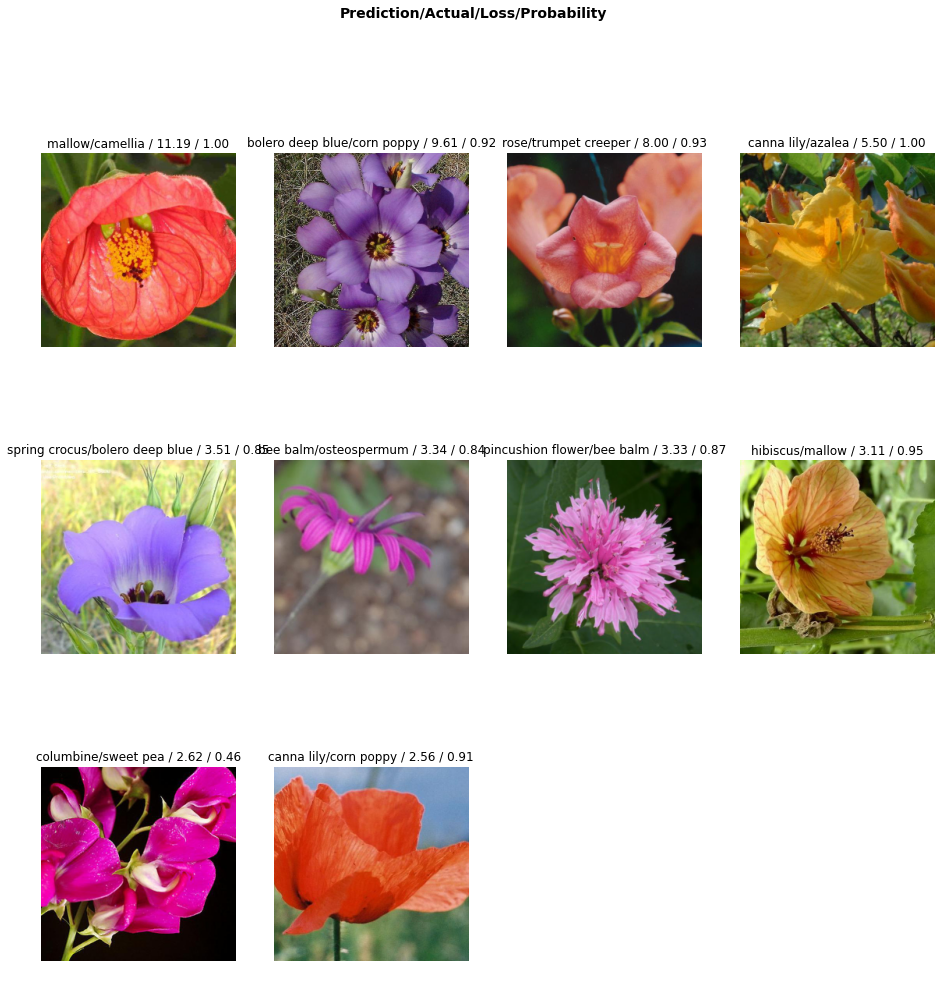

In [34]:
interp.plot_top_losses(10, figsize=(16, 16))

# Save/Load the model for Future use

> The saving and loading the trained model is easily possible by calling the expoort / load_learner functions. <br /><br />
⚠️ Keep in mind that you need to redefine the *get_x()* and *get_y()* functions before loading the learner.

In [ ]:
learn.export("finetuned_cls.pkl")

In [ ]:
def get_x(x): return path/x['link']
def get_y(x): return x['label']

learn = load_learner("finetuned_cls.pkl")

> Now, we can use the learner object *predict()* function to classify unseen images. It will take care of everything and pass the human-readable label.<br /><br />
This function is really flexible. You can pass either a path or image object or a list and take care of the rest.

In [ ]:
valid_df.iloc[0]['link'], valid_df.iloc[0]['label']

('jpg/image_04467.jpg', 'canna lily')

> **Example 1:** Pass the image path.

In [ ]:
learn.predict(path/'jpg/image_04467.jpg')

('canna lily',
 tensor(20),
 tensor([1.1540e-05, 4.9051e-04, 8.6535e-06, 2.3335e-04, 1.2844e-04, 1.1303e-06,
         8.6255e-07, 3.6378e-04, 1.4033e-05, 5.5322e-05, 1.7538e-06, 3.1079e-05,
         5.4625e-05, 1.5221e-05, 8.2359e-06, 8.0762e-05, 1.4338e-04, 2.1929e-05,
         2.0642e-06, 1.8233e-04, 9.8843e-01, 1.7822e-05, 2.4737e-06, 5.4024e-06,
         1.0876e-03, 2.7999e-06, 3.0364e-05, 2.8606e-04, 1.4151e-06, 1.0852e-04,
         8.1850e-06, 2.8904e-04, 3.5044e-05, 2.6807e-06, 7.4367e-05, 3.3023e-06,
         8.4567e-06, 1.1114e-04, 1.1492e-06, 2.9818e-06, 2.3636e-05, 5.0539e-04,
         3.1798e-05, 1.3168e-05, 3.2089e-04, 3.8871e-05, 9.9070e-07, 9.6428e-06,
         4.4628e-04, 3.7589e-05, 1.6994e-06, 4.1347e-05, 2.0511e-05, 9.3900e-06,
         4.9907e-06, 9.8451e-06, 7.9989e-05, 9.7891e-05, 5.6649e-07, 3.2996e-05,
         2.6548e-06, 6.8367e-05, 1.7496e-06, 5.1030e-05, 1.9012e-07, 8.4489e-07,
         4.3567e-06, 1.0611e-06, 9.9376e-05, 1.8500e-06, 6.1933e-07, 3.0804e-06,


> **Example 2:** Open the image and pass the image pixels.

In [ ]:
img_pixels = PILImage.create(path/'jpg/image_04467.jpg')

In [ ]:
img_pixels.shape

(621, 500)

In [ ]:
learn.predict( img_pixels )

('canna lily',
 tensor(20),
 tensor([1.1540e-05, 4.9051e-04, 8.6535e-06, 2.3335e-04, 1.2844e-04, 1.1303e-06,
         8.6255e-07, 3.6378e-04, 1.4033e-05, 5.5322e-05, 1.7538e-06, 3.1079e-05,
         5.4625e-05, 1.5221e-05, 8.2359e-06, 8.0762e-05, 1.4338e-04, 2.1929e-05,
         2.0642e-06, 1.8233e-04, 9.8843e-01, 1.7822e-05, 2.4737e-06, 5.4024e-06,
         1.0876e-03, 2.7999e-06, 3.0364e-05, 2.8606e-04, 1.4151e-06, 1.0852e-04,
         8.1850e-06, 2.8904e-04, 3.5044e-05, 2.6807e-06, 7.4367e-05, 3.3023e-06,
         8.4567e-06, 1.1114e-04, 1.1492e-06, 2.9818e-06, 2.3636e-05, 5.0539e-04,
         3.1798e-05, 1.3168e-05, 3.2089e-04, 3.8871e-05, 9.9070e-07, 9.6428e-06,
         4.4628e-04, 3.7589e-05, 1.6994e-06, 4.1347e-05, 2.0511e-05, 9.3900e-06,
         4.9907e-06, 9.8451e-06, 7.9989e-05, 9.7891e-05, 5.6649e-07, 3.2996e-05,
         2.6548e-06, 6.8367e-05, 1.7496e-06, 5.1030e-05, 1.9012e-07, 8.4489e-07,
         4.3567e-06, 1.0611e-06, 9.9376e-05, 1.8500e-06, 6.1933e-07, 3.0804e-06,


> See how the model finds the label from the final classification head output. It will use the argmax() function, which returns the index with the most probable output.

In [ ]:
outputs = torch.tensor([1.1540e-05, 4.9051e-04, 8.6535e-06, 2.3335e-04, 1.2844e-04, 1.1303e-06,
         8.6255e-07, 3.6378e-04, 1.4033e-05, 5.5322e-05, 1.7538e-06, 3.1079e-05,
         5.4625e-05, 1.5221e-05, 8.2359e-06, 8.0762e-05, 1.4338e-04, 2.1929e-05,
         2.0642e-06, 1.8233e-04, 9.8843e-01, 1.7822e-05, 2.4737e-06, 5.4024e-06,
         1.0876e-03, 2.7999e-06, 3.0364e-05, 2.8606e-04, 1.4151e-06, 1.0852e-04,
         8.1850e-06, 2.8904e-04, 3.5044e-05, 2.6807e-06, 7.4367e-05, 3.3023e-06,
         8.4567e-06, 1.1114e-04, 1.1492e-06, 2.9818e-06, 2.3636e-05, 5.0539e-04,
         3.1798e-05, 1.3168e-05, 3.2089e-04, 3.8871e-05, 9.9070e-07, 9.6428e-06,
         4.4628e-04, 3.7589e-05, 1.6994e-06, 4.1347e-05, 2.0511e-05, 9.3900e-06,
         4.9907e-06, 9.8451e-06, 7.9989e-05, 9.7891e-05, 5.6649e-07, 3.2996e-05,
         2.6548e-06, 6.8367e-05, 1.7496e-06, 5.1030e-05, 1.9012e-07, 8.4489e-07,
         4.3567e-06, 1.0611e-06, 9.9376e-05, 1.8500e-06, 6.1933e-07, 3.0804e-06,
         2.1046e-06, 3.6004e-05, 1.1501e-06, 1.0843e-05, 2.5480e-06, 6.5637e-05,
         7.6813e-04, 1.4332e-05, 1.9169e-04, 8.0272e-06, 6.3818e-04, 1.0742e-05,
         4.1863e-05, 5.0110e-06, 1.1787e-05, 7.6231e-05, 1.8439e-07, 4.3020e-04,
         3.6580e-06, 8.6303e-05, 4.5532e-06, 1.0802e-06, 3.7461e-06, 2.7674e-03,
         2.2809e-04, 1.0974e-07, 7.3315e-05, 5.9624e-07, 1.4498e-06, 1.9486e-04])

In [ ]:
outputs.argmax()

tensor(20)

In [ ]:
learn.dls.vocab[20]

'canna lily'

> End of Vision Part 1.

# Workshop Resources

> Go to [Vision Part 2](https://colab.research.google.com/github/AlaFalaki/workshop-materials/blob/main/2021-practical-deep-learning/04-Vision_Part2.ipynb) notebook. (PyTorch vs. FastAi)<br /><br />
> Also, this [Github Repository](https://github.com/AlaFalaki/workshop-materials/tree/main/2021-practical-deep-learning) contains all the notebooks and materials presented in this workshop.

# References

1. *Nilsback, M.-E, and A Zisserman. “A Visual Vocabulary for Flower Classification.” In 2006 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR’06), 2:1447–1454. IEEE, 2006.*

2. *He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. "Deep residual learning for image recognition." In Proceedings of the IEEE conference on computer vision and pattern recognition, pp. 770-778. 201*